## Discrete Data + Probability
- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import seaborn as sns

import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint

%matplotlib inline

<h3>Acquire the Data</h3>

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.request_method.value_counts()

"GET /api/v1/sales?page=2 HTTP/1.1"                 709
"GET /api/v1/items HTTP/1.1"                        464
"GET /api/v1/items?page=2 HTTP/1.1"                 291
"GET /api/v1/items?page=3 HTTP/1.1"                 219
"GET /api/v1/stores HTTP/1.1"                       162
                                                   ... 
"GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1"              1
"GET /api/v1 HTTP/1.1"                                1
GET /api/v1/items/HTTP/1.1                            1
"GET /api/v1/items?page=4 HTTP/1.1"                   1
"GET /api/v1/items/api/v1/items?page=3 HTTP/1.1"      1
Name: request_method, Length: 220, dtype: int64

#### Parse Datetime:

In [6]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [7]:
df.head(1)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [8]:
# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime

df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# reset index to time
df = df.set_index('timestamp')

In [9]:
df.head(1)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


-----

<h3>Cleanup Text</h3>

----

In [10]:
# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r' HTTP/1.1', '', regex=True)

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'HTTP/1.1', '', regex=True)

df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,python-requests/2.21.0


In [11]:
#### Add Variable - Converting bytes to mb:

df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.describe()


,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [13]:
df.request_method.value_counts()

GET /api/v1/sales                      12403
GET /api/v1/items                       1065
GET /api/v1/stores                       229
GET /                                    107
GET /documentation                       100
GET /favicon.ico                          26
GET /api/v1//api/v1/items                 11
GET /api/v1/items/api/v1/items             7
GET /api/v1/sales/                         6
GET /api/v1/items/next_page                5
GET /api/v1/                               4
GET /api/v1/itemsitems                     3
GET /api/v1/store                          3
GET /api/v1items                           2
GET /api/v1/helloclass!                    1
GET /api/V1/HiZach!                        1
GET /api/v1/I_DIDNT_DO_IT!!!!              1
GET /api/v1/items&page=0                   1
GET /api/v1                                1
GET /api/v1/items/                         1
GET /api/v1//api/v1/items/next_page        1
Name: request_method, dtype: int64

## Detecting Anomalies in Discrete Variables

### Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [14]:
# get the counts of ips in the dataset
rm_df = df.request_method.value_counts(dropna=False).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'request_method_count'})

In [15]:
rm_df.head()

,request_method,request_method_count
0,GET /api/v1/sales,12403
1,GET /api/v1/items,1065
2,GET /api/v1/stores,229
3,GET /,107
4,GET /documentation,100


In [16]:
# get the probability of that ip in the dataset
rm_df2 = (df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'request_method_proba'})


In [17]:
rm_df2.head()

,request_method,request_method_proba
0,GET /api/v1/sales,0.887323
1,GET /api/v1/items,0.076191
2,GET /api/v1/stores,0.016383
3,GET /,0.007655
4,GET /documentation,0.007154


In [18]:
# merge/join these together
rm_df = rm_df.merge(rm_df2)

In [19]:
rm_df.head()

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales,12403,0.887323
1,GET /api/v1/items,1065,0.076191
2,GET /api/v1/stores,229,0.016383
3,GET /,107,0.007655
4,GET /documentation,100,0.007154


In [20]:
rm_df.shape

(21, 3)

In [21]:
# alter the ip df to only see those where rate < 1% 
rm_df[rm_df.request_method_proba < 0.01]

,request_method,request_method_count,request_method_proba
3,GET /,107,0.007655
4,GET /documentation,100,0.007154
5,GET /favicon.ico,26,0.001860
6,GET /api/v1//api/v1/items,11,0.000787
7,GET /api/v1/items/api/v1/items,7,0.000501
8,GET /api/v1/sales/,6,0.000429
9,GET /api/v1/items/next_page,5,0.000358
10,GET /api/v1/,4,0.000286
11,GET /api/v1/itemsitems,3,0.000215
12,GET /api/v1/store,3,0.000215


21
                         request_method  request_method_count  \
11               GET /api/v1/itemsitems                     3   
12                    GET /api/v1/store                     3   
13                     GET /api/v1items                     2   
14              GET /api/v1/helloclass!                     1   
15                  GET /api/V1/HiZach!                     1   
16        GET /api/v1/I_DIDNT_DO_IT!!!!                     1   
17             GET /api/v1/items&page=0                     1   
18                          GET /api/v1                     1   
19                   GET /api/v1/items/                     1   
20  GET /api/v1//api/v1/items/next_page                     1   

    request_method_proba  
11              0.000215  
12              0.000215  
13              0.000143  
14              0.000072  
15              0.000072  
16              0.000072  
17              0.000072  
18              0.000072  
19              0.000072  
20         

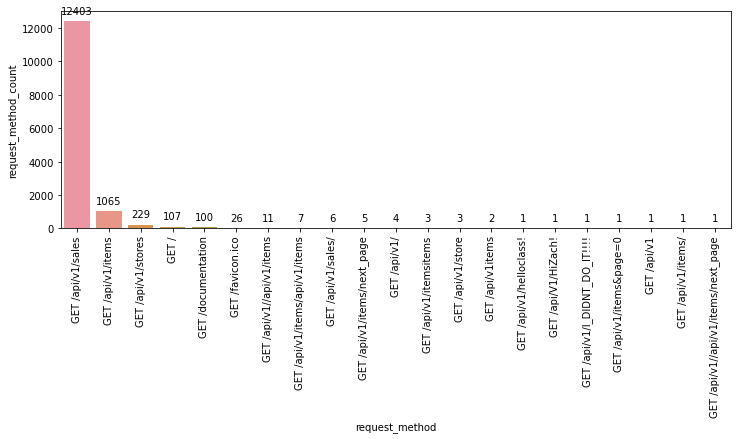

In [22]:
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'request_method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation='vertical')
plt.show()

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.
#### Establish Baseline:

In [23]:
df.shape

(13978, 7)

In [24]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [25]:
train.shape

(13974, 7)

In [26]:
train.size /df.size

0.9997138360280441

In [27]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [28]:
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,NaN,python-requests/2.21.0,0.488246


#### Compute probabilities based on train sample:

In [29]:
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [30]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,request_method_count,request_method_proba
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,12403,0.887323
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,0,python-requests/2.21.0,0.003396,1065,0.076191
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,0,python-requests/2.21.0,0.486472,12403,0.887323
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,0,python-requests/2.21.0,0.486377,12403,0.887323
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,0,python-requests/2.21.0,0.488246,12403,0.887323


In [31]:
df.request_method_proba.value_counts()

0.887323    12403
0.076191     1065
0.016383      229
0.007655      107
0.007154      100
0.001860       26
0.000787       11
0.000072        7
0.000501        7
0.000215        6
0.000429        6
0.000358        5
0.000286        4
0.000143        2
Name: request_method_proba, dtype: int64

There is nothing that needs to be filled with zero

---

### Conditional Probabilities: Probabilities using 2 discrete variables

#### Probability of Status given request_method:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address. 


----

In [32]:
# prob(A|B) = prob(A & B) / prob(B)

In [33]:
request_method_probs = train.groupby('request_method').size().div(len(train))

status_given_rm = pd.DataFrame(train.groupby(['request_method', 'status']).size().div(len(train)).\
                              div(request_method_probs,
                                 axis=0,
                                 level='request_method').\
                              reset_index().\
                              rename(columns={0: 'proba_status_given_rm'})
                              )

In [34]:
rm_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'rm_status_count'}))


rm_status = status_given_rm.merge(rm_status_count)

In [36]:
rm_status


,request_method,status,proba_status_given_rm,ip,rm_status_count
0,GET /,200,1.000000,173.173.113.51,1059
1,GET /,200,1.000000,24.26.242.9,21
2,GET /,200,1.000000,3.88.129.158,1
3,GET /,200,1.000000,3.92.201.136,1
4,GET /,200,1.000000,34.207.64.242,1
...,...,...,...,...,...
379,GET /favicon.ico,200,1.000000,97.105.19.58,11984
380,GET /api/v1/items,499,0.003756,72.181.113.170,2
381,GET /api/v1/items,499,0.003756,97.105.19.58,14
382,GET /api/v1/sales,499,0.000968,72.181.113.170,2


In [41]:
df.head(1)

,ip,request_method,status,size,destination,request_agent,size_mb,request_method_count,request_method_proba
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,12403,0.887323


#### Add these probabilities to original events to detect anomalous events:

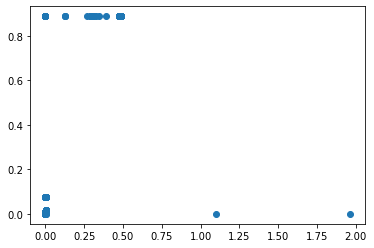

In [43]:
# scatter plot
plt.scatter(df.size_mb, df.request_method_proba)
plt.show()